In [1]:
from pyspark.sql import SparkSession

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [6]:
from pyspark.sql.functions import col, udf, trim, isnull
from pyspark.sql.types import FloatType, IntegerType

In [7]:
def to_float (s) :
   return float(s.replace(',','.'))
float_udf = udf(to_float , FloatType())

In [8]:
countries = spark.read.csv("data/countries of the world.csv",inferSchema=True,header=True)

# Usuwa kropki ze wszystkich nazw kolumn (powodują wiele błędów, prawdopodobnie bug w Sparku)
# (Nb. wszystkie inne metody zmiany tych nazw (np. użycie columnRenamed) zawiodły)
new_columns=[s.replace('.','') for s in countries.columns]
countries=countries.toDF(*new_columns) # tutaj '*' to operator "splat" -- robi z tablicy listę argumentów

# Tak można ustawić wyświetlanie większej liczby wierszy w Jupyterze
pd.set_option('display.max_rows', 120)
display(countries.toPandas())

,Country,Region,Population,Area (sq mi),Pop Density (per sq mi),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,None,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",None,None,NaN,None,None,"0,02",0,"99,98",1,None,None,None,None,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


In [9]:
# Utworzenie ramki 'cdf' -- konwersja wszystkich kolumn zmiennoprzecinkowych na float + trim stringów
cdf=countries.na.fill("-1").select( # wartosci puste wypelnione "-1", zeby nie usuwac wierszy
                 trim(col('Country')).alias('Country'),\
                 trim(col('Region')).alias('Region'),'Population',\
                 col('Area (sq mi)').alias('Area (sq km)'),\
                 float_udf('Pop Density (per sq mi)').alias('Pop Density (per sq km)'),\
                 float_udf('Coastline (coast/area ratio)').alias('Coastline (coast/area ratio)'),\
                 float_udf('Net migration').alias('Net migration'),\
                 float_udf('Infant mortality (per 1000 births)').alias('Infant mortality (per 1000 births)'),\
                 'GDP ($ per capita)',\
                 float_udf('Literacy (%)').alias('Literacy (%)'),\
                 float_udf('Phones (per 1000)').alias('Phones (per 1000)'),\
                 float_udf('Arable (%)').alias('Arable (%)'),\
                 float_udf('Crops (%)').alias('Crops (%)'),\
                 float_udf('Other (%)').alias('Other (%)'),\
                 float_udf('Birthrate').alias('Birthrate'),\
                 float_udf('Deathrate').alias('Deathrate'),\
                 float_udf('Agriculture').alias('Agriculture'),\
                 float_udf('Industry').alias('Industry'),\
                 float_udf('Service').alias('Service'))

In [11]:
airports = spark.read.csv("data/airports-2.csv",inferSchema=True,header=False).\
        toDF("id","airport","city","country","iata","icao","latitude","longitude","altitude","timezone","dst","tz_timezone","type","data_source")

# 1. Print all the airports that are to the North from Krakow.

In [12]:
ref_lat = airports.select('latitude').\
     where(col('City').like('%Krakow%')).collect()[0][0]

airports.select('City', 'Airport', 'latitude').where(col('latitude')>ref_lat).\
     sort(col("latitude").desc()).toPandas()

,City,Airport,latitude
0,Alert,Alert Airport,82.517799
1,Murmansk,Nagurskoye,80.803207
2,Eureka,Eureka Airport,79.994698
3,Ny-Alesund,Ny-Ålesund Airport (Hamnerabben),78.927498
4,Svalbard,"Svalbard Airport, Longyear",78.246101
...,...,...,...
1407,Sioux Lookout,Sioux Lookout Airport,50.113899
1408,Rzeszow,Rzeszów-Jasionka Airport,50.110001
1409,Land's End,Land's End Airport,50.102798
1410,Prague,Václav Havel Airport Prague,50.100800


# 2. For each state, find the airport which is closest to the South Pole.

In [13]:
from pyspark.sql.functions import min

south_ports=airports.select('Country','Airport','latitude').\
       groupBy('Country').agg(min("latitude").alias('latitude'))

south_ports.toPandas()

,Country,latitude
0,Chad,8.624410
1,Paraguay,-27.370554
2,Anguilla,18.204800
3,Russia,-36.242155
4,British Indian Ocean Territory,-7.313270
...,...,...
232,United Kingdom,28.167000
233,Moldova,45.843800
234,Vietnam,8.731830
235,Netherlands,50.911701


In [14]:
a=south_ports.alias('a')
b=airports.alias('b')

a.join(b, col('a.latitude')==col('b.latitude')).\
select('a.Country','b.Airport',col('a.latitude').alias('Latitude')).\
sort(col("a.Country").asc()).toPandas()

,Country,Airport,Latitude
0,Afghanistan,Zaranj Airport,30.972222
1,Albania,Vlorë Air Base,40.476101
2,Algeria,Bordj Badji Mokhtar Airport,21.375000
3,American Samoa,Pago Pago International Airport,-14.331000
4,Angola,Ngjiva Pereira Airport,-17.043501
...,...,...,...
233,West Bank,Jerusalem Airport,31.864700
234,Western Sahara,Dakhla Airport,23.718300
235,Yemen,Socotra International Airport,12.630700
236,Zambia,Livingstone Airport,-17.821800


# 3. Plot the coordinates of all the airports. Bonus: plot on the map.

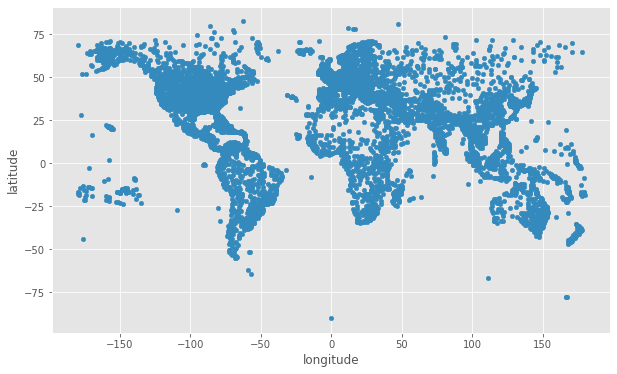

In [15]:
#from mpl_toolkits.basemap import Basemap
#arp=airports.select('Airport','latitude','longitude').where(col("Country").like("%United States%")).sort(col('Airport').asc())
arp=airports.select('Airport','latitude','longitude').sort(col('Airport').asc())
arp.toPandas().plot(x="longitude",y="latitude",kind="scatter",figsize=(10, 6))


# 4. Plot GDP vs. Phones for all countries in Asia.

In [16]:
gdp_phone=cdf.select('Country', 'GDP ($ per capita)', 'Phones (per 1000)').where(col('Region').like('%ASIA%'))

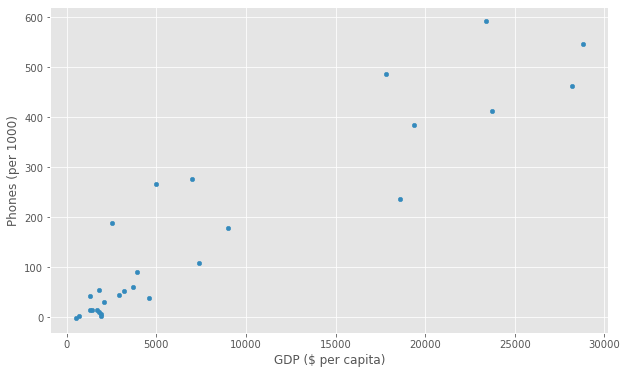

In [17]:
gdp_phone.toPandas().plot(x='GDP ($ per capita)',y='Phones (per 1000)',kind='scatter',figsize=(10, 6))

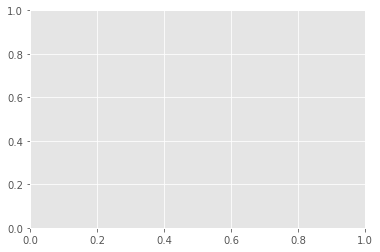

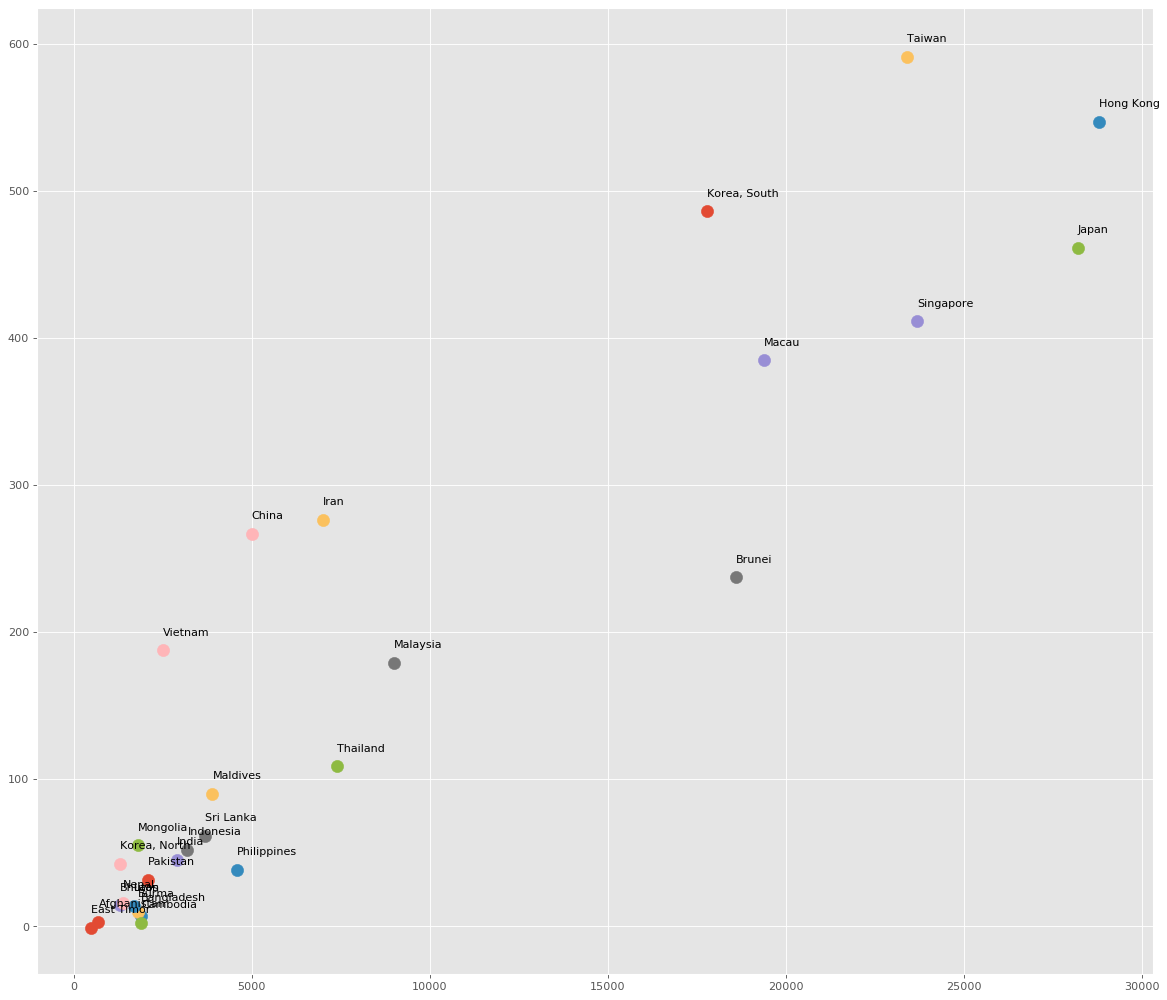

In [18]:
# dodanie etykiet obok punktów (niedopracowane)
from matplotlib import cm
#ax = plt.subplots()
gp=gdp_phone.toPandas()
cmap = cm.get_cmap('Spectral')
#ax=gp.plot(x='GDP ($ per capita)', y='Phones', kind='scatter', s=120, linewidth=0, c=range(len(gp)), colormap=cmap)
ax=plt.subplots()
fig=plt.figure(figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
for k, v in gp.iterrows():
    x=v['GDP ($ per capita)']
    y=v['Phones (per 1000)']
    label=v['Country']
    plt.scatter(x,y,s=120)
    plt.text(x,y+10.0,label) 

# 5. Plot Infant mortality vs. Literacy for top 30 richest and top 30 poorest countries.

In [19]:
cdf.printSchema()

root
 |-- Country: string (nullable = false)
 |-- Region: string (nullable = false)
 |-- Population: integer (nullable = true)
 |-- Area (sq km): integer (nullable = true)
 |-- Pop Density (per sq km): float (nullable = true)
 |-- Coastline (coast/area ratio): float (nullable = true)
 |-- Net migration: float (nullable = true)
 |-- Infant mortality (per 1000 births): float (nullable = true)
 |-- GDP ($ per capita): integer (nullable = true)
 |-- Literacy (%): float (nullable = true)
 |-- Phones (per 1000): float (nullable = true)
 |-- Arable (%): float (nullable = true)
 |-- Crops (%): float (nullable = true)
 |-- Other (%): float (nullable = true)
 |-- Birthrate: float (nullable = true)
 |-- Deathrate: float (nullable = true)
 |-- Agriculture: float (nullable = true)
 |-- Industry: float (nullable = true)
 |-- Service: float (nullable = true)



In [23]:
mbdf_poor=cdf.select('Country','Infant mortality (per 1000 births)', 'Literacy (%)', 'GDP ($ per capita)').sort(col('GDP ($ per capita)').asc()).limit(30)


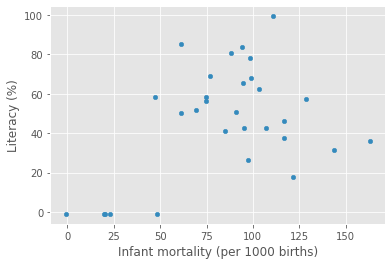

In [24]:
mbdf_poor.toPandas().plot.scatter('Infant mortality (per 1000 births)','Literacy (%)')

In [25]:
mbdf_rich=cdf.select('Country','Infant mortality (per 1000 births)', 'Literacy (%)', 'GDP ($ per capita)').sort(col('GDP ($ per capita)').desc()).limit(30)


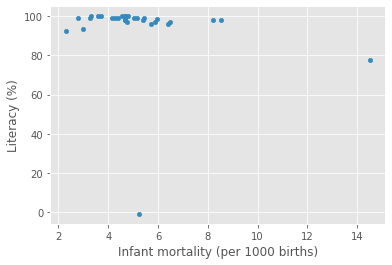

In [26]:
# mbdf_rich.toPandas()
mbdf_rich.toPandas().plot.scatter('Infant mortality (per 1000 births)','Literacy (%)')